Train shape: (25000, 14) | Test shape: (23842, 14) | Submission shape: (23842, 2)

    age         workclass    education  education.num      marital.status  \
0   53  Self-emp-not-inc  Prof-school             15  Married-civ-spouse   
1   33  Self-emp-not-inc    Bachelors             13  Married-civ-spouse   
2   47           Private      HS-grad              9  Married-civ-spouse   
3   40           Private      HS-grad              9            Divorced   
4   39           Private      HS-grad              9  Married-civ-spouse   

         occupation    relationship                race     sex  capital.gain  \
0    Prof-specialty         Husband  Asian-Pac-Islander    Male             0   
1   Exec-managerial         Husband               White    Male             0   
2      Craft-repair         Husband               White    Male             0   
3      Craft-repair  Other-relative               White  Female             0   
4  Transport-moving         Husband               Whit

<AxesSubplot:xlabel='income>50K', ylabel='count'>

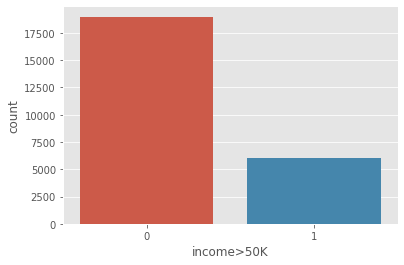

In [46]:
import csv
import warnings
warnings.filterwarnings('ignore')

import os

import pandas as pd
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
from tqdm import tqdm_notebook as tqdm

from sklearn.model_selection import train_test_split
from sklearn import metrics, preprocessing


# X Train
traindf = pd.read_csv("in-csv/train_final.csv")
# X Test
testdf = pd.read_csv("in-csv/test_final.csv")

#try dropping fnlwgt
traindf = traindf.drop('fnlwgt', axis=1)
testdf = testdf.drop('fnlwgt', axis=1)

# X Sample
sampledf = pd.read_csv("in-csv/sample_final.csv")


# -----------Data Exploration-------------

print(f'Train shape: {traindf.shape}',
      f'Test shape: {testdf.shape}',
      f'Submission shape: {sampledf.shape}', sep=' | ')

print("\n", traindf.head())

sns.countplot(traindf.iloc[:, -1])

In [47]:
# View uniques values of train data

traindf.index.nunique(), len(traindf.index)

traindf.head()

nunique_vals = list()

for column in traindf:
    nunique_vals.append(traindf[column].nunique())
    
pd.DataFrame({'columns': traindf.columns,
              'num_of_unique': nunique_vals})

,columns,num_of_unique
0,age,73
1,workclass,9
2,education,16
3,education.num,16
4,marital.status,7
5,occupation,15
6,relationship,6
7,race,5
8,sex,2
9,capital.gain,117


In [48]:

# View uniques values of train and test data

all_df = pd.concat([traindf, testdf], axis=0, ignore_index=True)

all_df.index.nunique(), len(all_df.index)

all_df = all_df.drop('ID', axis=1)

all_df.head()

nunique_vals = list()

for column in all_df:
    nunique_vals.append(all_df[column].nunique())
    
pd.DataFrame({'columns': all_df.columns,
              'num_of_unique': nunique_vals})

,columns,num_of_unique
0,age,74
1,workclass,9
2,education,16
3,education.num,16
4,marital.status,7
5,occupation,15
6,relationship,6
7,race,5
8,sex,2
9,capital.gain,123


In [49]:
# Check for NaN Values

for column in all_df.columns:

    unique_values = all_df[column].unique()
    
    print(f'Statistics fot column: {column}')
    print(f'Column unique values:\n {unique_values}')
    print(f'Number of unique values: {len(unique_values)}')
    print(f'Number of NAN values: {all_df[column].isna().sum()}')
    print('_' * 50)

Statistics fot column: age
Column unique values:
 [53 33 47 40 39 55 22 27 37 79 31 19 21 56 26 42 30 35 68 38 34 32 72 24
 50 28 49 29 51 48 41 66 60 20 76 45 52 18 44 59 75 71 46 23 17 54 36 25
 57 43 58 64 61 70 90 81 85 62 65 69 67 80 63 77 78 73 84 74 88 83 82 87
 89 86]
Number of unique values: 74
Number of NAN values: 0
__________________________________________________
Statistics fot column: workclass
Column unique values:
 ['Self-emp-not-inc' 'Private' 'Federal-gov' 'Local-gov' 'Self-emp-inc' '?'
 'State-gov' 'Never-worked' 'Without-pay']
Number of unique values: 9
Number of NAN values: 0
__________________________________________________
Statistics fot column: education
Column unique values:
 ['Prof-school' 'Bachelors' 'HS-grad' 'Doctorate' 'Masters' 'Some-college'
 '11th' '12th' '5th-6th' 'Assoc-acdm' '9th' 'Preschool' 'Assoc-voc'
 '7th-8th' '10th' '1st-4th']
Number of unique values: 16
Number of NAN values: 0
__________________________________________________
Statistics fot

In [50]:
# Features encoding

# Possibly drop fnlwgt???
#all_df = all_df.drop('fnlwgt', axis=1)

categorical = ['workclass', 'education', 'marital.status', 'occupation',
               'relationship', 'race', 'sex', 'native.country']

continuous = ['age','education.num','capital.gain','capital.loss','hours.per.week']

# Use LabelEncoding to change string values to numbers

features = [x for x in all_df.columns 
            if x not in ['ID', 'income>50K'] + continuous]

for feat in tqdm(features):
    lbl_enc = preprocessing.LabelEncoder()
    
    all_df[feat] = lbl_enc.fit_transform(all_df[feat]. \
                                         fillna('-1'). \
                                         astype(str).values)
    
all_df['income>50K'] = all_df['income>50K'].fillna(-1)
all_df[continuous] = all_df[continuous].fillna(-2)


  0%|          | 0/8 [00:00<?, ?it/s]

In [51]:
# Print Information

all_df.head()

all_df.shape

all_df.isna().sum().sum()

0

In [52]:
# Prepare Data for Training and Testing

train = all_df[:traindf.shape[0]]
test = all_df[traindf.shape[0]:]

print(f'Train shape: {train.shape}',
      f'Test shape: {test.shape}', sep=' | ')

train.isna().sum().sum(), test.isna().sum().sum() 

train_data = train.drop('income>50K', axis=1).to_numpy()
train_target = train['income>50K'].to_numpy()

test_data = test.drop('income>50K', axis=1).to_numpy()

categorical = all_df.drop(['income>50K'] + continuous,
                          axis=1).columns

cat_cols_idx, cont_cols_idx = list(), list()

for idx, column in enumerate(all_df.drop('income>50K',
                                         axis=1).columns):
    if column in categorical:
        cat_cols_idx.append(idx)
    elif column in continuous:
        cont_cols_idx.append(idx)

train_data, train_target, test_data


Train shape: (25000, 14) | Test shape: (23842, 14)


(array([[53,  6, 14, ...,  0, 40, 19],
        [33,  6,  9, ...,  0, 40, 39],
        [47,  4, 11, ...,  0, 40, 39],
        ...,
        [39,  4, 12, ...,  0, 40, 31],
        [53,  4, 11, ...,  0, 46, 39],
        [18,  0, 15, ...,  0, 40, 39]]),
 array([1., 1., 0., ..., 0., 1., 0.]),
 array([[33,  6, 11, ...,  0, 40, 39],
        [68,  0, 11, ...,  0, 12, 39],
        [34,  4, 11, ...,  0, 40, 39],
        ...,
        [67,  5, 15, ...,  0, 20, 39],
        [46,  2,  7, ...,  0, 40, 39],
        [66,  1,  0, ...,  0, 40, 39]]))

In [53]:
class NN(nn.Module):
    def __init__(self, hidden_width, depth, activation):
        super(NN, self).__init__()
        layers = []
        input_layer = nn.Linear(13, hidden_width)
        if activation == "relu":
            activation_input = nn.ReLU()
        else:
            activation_input = nn.Tanh()

        layers.append(input_layer)
        layers.append(activation_input)
        for i in range(depth-1):
            hidden_layer = nn.Linear(hidden_width, hidden_width)
            if activation == "relu":
                activation_hidden = nn.ReLU()
            else:
                activation_hidden = nn.Tanh()

            layers.append(hidden_layer)
            layers.append(activation_hidden)

        output_layer = nn.Linear(hidden_width, 1)
        layers.append(output_layer)

        self.model = nn.Sequential(*layers)

        def init_weights_relu(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.kaiming_uniform_(m.weight)

        def init_weights_tanh(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)

        if activation == 'relu':
            self.model.apply(init_weights_relu)
        else:
            self.model.apply(init_weights_tanh)

    def forward(self, X):
        input = np.float32(X)
        out = torch.from_numpy(input)
        out.requires_grad = True
        return self.model(out)

In [54]:
#Training

print("\nTanh:\n")

depth = [3, 5, 9]
width = [5, 10, 25, 50, 100]
criterion = torch.nn.MSELoss(reduction='sum')

for i in width:
    for j in depth:
        NeuralNet = NN(i, j, "tanh")
        optimizer = torch.optim.SGD(NeuralNet.parameters(), lr=0.01, momentum=0.9)

        for t in range(1000):

            optimizer.zero_grad()

            # Forward pass: compute predicted y by passing x to the model.
            y_train_pred_tensor = NeuralNet.forward(train_data).flatten()

            y_train_np = np.float32(train_target)
            y_train_tensor = torch.from_numpy(y_train_np)
            y_train_tensor.requires_grad = True
            y_train_tensor = y_train_pred_tensor.flatten()

            # print(y_train_pred_tensor)

            # print(y_train_tensor)

            loss = criterion(y_train_pred_tensor.flatten(), y_train_tensor)

            # Backward pass: compute gradient of the loss with respect to model
            loss.backward()

            # Calling the step function on an Optimizer makes an update to its parameters
            optimizer.step()

        #train error
        train_pred = NeuralNet.forward(train_data)

        train_pred[train_pred >= 0] = 1

        train_pred[train_pred < 0] = 0

        train_pred = train_pred.detach().numpy().flatten()

        train_pred = train_pred.astype(int)

        train_error = 1 - np.mean(train_pred == train_target)

        print(f"width: {i}, depth:{j}, train error: {train_error.round(3)}")

        #test predictions -> add to csv

        test_pred = NeuralNet.forward(test_data)

        test_pred[test_pred >= 0] = 1

        test_pred[test_pred < 0] = 0

        test_pred = test_pred.detach().numpy().flatten()
        
        test_pred = test_pred.astype(int)

        nn_predictions_df = pd.DataFrame({'ID': sampledf['ID'], 
                                   'Prediction': test_pred})

        nn_predictions_df.to_csv("out-csv/" + "tanh-" + "width-" + str(i) + "-depth-" + str(j) + ".csv", index=False)




Tanh:

width: 5, depth:3, train error: 0.56
width: 5, depth:5, train error: 0.241
width: 5, depth:9, train error: 0.404
width: 10, depth:3, train error: 0.241
width: 10, depth:5, train error: 0.759
width: 10, depth:9, train error: 0.241
width: 25, depth:3, train error: 0.767
width: 25, depth:5, train error: 0.753
width: 25, depth:9, train error: 0.469
width: 50, depth:3, train error: 0.25
width: 50, depth:5, train error: 0.521
width: 50, depth:9, train error: 0.759
width: 100, depth:3, train error: 0.368
width: 100, depth:5, train error: 0.778


KeyboardInterrupt: 

In [50]:
#Training

print("\nReLu:\n")

depth = [3, 5, 9]
width = [5, 10, 25, 50, 100]
criterion = criterion = torch.nn.MSELoss(reduction='sum')

for i in width:
    for j in depth:
        NeuralNet = NN(i, j, "relu")
        optimizer = torch.optim.SGD(NeuralNet.parameters(), lr=0.01, momentum=0.9)
        for t in range(1000):

            optimizer.zero_grad()

            # Forward pass: compute predicted y by passing x to the model.
            y_train_pred_tensor = NeuralNet.forward(train_data).flatten()

            y_train_np = np.float32(train_target)
            y_train_tensor = torch.from_numpy(y_train_np)
            y_train_tensor.requires_grad = True
            y_train_tensor = y_train_pred_tensor.flatten()

            # print(y_train_pred_tensor)

            # print(y_train_tensor)

            loss = criterion(y_train_pred_tensor.flatten(), y_train_tensor)

            # Backward pass: compute gradient of the loss with respect to model
            loss.backward()

            # Calling the step function on an Optimizer makes an update to its parameters
            optimizer.step()

        #train error
        train_pred = NeuralNet.forward(train_data)

        train_pred[train_pred >= 0] = 1

        train_pred[train_pred < 0] = 0

        train_pred = train_pred.detach().numpy().flatten()

        train_pred = train_pred.astype(int)

        train_error = 1 - np.mean(train_pred == train_target)

        print(f"width: {i}, depth:{j}, train error: {train_error.round(3)}")

        #test predictions -> add to csv

        test_pred = NeuralNet.forward(test_data)

        test_pred[test_pred >= 0] = 1

        test_pred[test_pred < 0] = 0

        test_pred = test_pred.detach().numpy().flatten()
        
        test_pred = test_pred.astype(int)

        nn_predictions_df = pd.DataFrame({'ID': sampledf['ID'], 
                                   'Prediction': test_pred})

        nn_predictions_df.to_csv("out-csv/" + "relu-" + "width-" + str(i) + "-depth-" + str(j) + ".csv", index=False)




ReLu:

width: 5, depth:3, train error: 0.757
width: 5, depth:5, train error: 0.758
width: 5, depth:9, train error: 0.759
width: 10, depth:3, train error: 0.758
width: 10, depth:5, train error: 0.759
width: 10, depth:9, train error: 0.759
width: 25, depth:3, train error: 0.242
width: 25, depth:5, train error: 0.759
width: 25, depth:9, train error: 0.242
width: 50, depth:3, train error: 0.737
width: 50, depth:5, train error: 0.241
width: 50, depth:9, train error: 0.293


KeyboardInterrupt: 

In [284]:
import shutil
shutil.make_archive('submissions', 'zip', 'out-csv')

'/Users/janalynjenn/Desktop/FinalProjectMachineLearning/submissions.zip'